In [27]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device disponible: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory available: {torch.cuda.mem_get_info()[0] / 1024**3:.1f} GB")

Device disponible: cuda
GPU: NVIDIA GeForce RTX 3070 Laptop GPU
Memory available: 6.9 GB


In [22]:
import pandas as pd
from src.utils.yield_curve_data import load_preprocessed_yield_curve, prepare_yield_curve_for_kan

raw_dataset = pd.read_csv("data/raw/fred_yield_curve.csv", index_col=0, parse_dates=True).drop(columns=["1M"])

df_cross_section, df_column_wise = load_preprocessed_yield_curve(
    start="1990-01-01",
    normalization="both"
)

Loading existing file: data\raw\fred_yield_curve.csv
FRED Yield Curve: 9303 rows × 8 cols
Column 1M has 3020 NaNs
Dropping columns: ['1M']
Cross-section z-score shape: (9303, 7)
Column-wise z-score shape: (9303, 7)


In [23]:
df_cross_section
df_column_wise
raw_dataset

,3M,6M,1Y,2Y,5Y,10Y,30Y
DATE,,,,,,,
1990-01-02,7.83,7.89,7.81,7.87,7.87,7.94,8.00
1990-01-03,7.89,7.94,7.85,7.94,7.92,7.99,8.04
1990-01-04,7.84,7.90,7.82,7.92,7.91,7.98,8.04
1990-01-05,7.79,7.85,7.79,7.90,7.92,7.99,8.06
1990-01-08,7.79,7.88,7.81,7.90,7.92,8.02,8.09
...,...,...,...,...,...,...,...
2025-08-22,4.27,4.08,3.87,3.68,3.76,4.26,4.88
2025-08-25,4.29,4.08,3.88,3.73,3.80,4.28,4.89
2025-08-26,4.28,4.06,3.85,3.61,3.75,4.26,4.90


In [29]:
# Split the data into train, validation and test sets
# Use time-based split since this is financial time series data

# Calculate split points 
n_samples = len(raw_dataset)
train_size = int(0.7 * n_samples)  # 70% for training
val_size = int(0.15 * n_samples)   # 15% for validation

# Split the data chronologically
train_data = raw_dataset.iloc[:train_size]
val_data = raw_dataset.iloc[train_size:train_size+val_size] 
test_data = raw_dataset.iloc[train_size+val_size:]

# Convert to tensors
X_train = torch.tensor(train_data.values, dtype=torch.float32)
X_val = torch.tensor(val_data.values, dtype=torch.float32)
X_test = torch.tensor(test_data.values, dtype=torch.float32)

# print(f"Training set: {len(X_train)} samples ({len(train_data.index[0])} to {train_data.index[-1]})")
# print(f"Validation set: {len(X_val)} samples ({val_data.index[0]} to {val_data.index[-1]})")
# print(f"Test set: {len(X_test)} samples ({test_data.index[0]} to {test_data.index[-1]})")


In [63]:
from src.models.gated_kan_ae import GatedKANAutoencoder

# Initialize model with 7 input features (yield curve tenors)
# and 3 latent dimensions for level, slope, curvature to see if you can verify the Nelson-Siegel curve

gated_kan = GatedKANAutoencoder(
    input_dim=raw_dataset.shape[1],
    k=3,
    hidden_dims=[5, 4],
    
    basis_type="spline",
    M=16,
    poly_degree=5,
    xmin=-3.5,
    xmax=3.5,
    dropout_p=0.001,
    use_silu=True,
    
    gate_init=0.5,
    skip_rank=None,
    
    loss_type="huber",
    huber_delta=1,
    
    lambda_alpha=0.0001,
    lambda_group=0.00001,
    lambda_tv=0.0001,
    lambda_poly_decay=0,
    lambda_orthogonal=0.01,
    lambda_gate_reg=0.0001
)


In [64]:
history = gated_kan.fit(
        X_train=X_train,
        X_val=X_val,
        validation_split=0.2,
        epochs=150, 
        batch_size=64,
        learning_rate=0.0001, 
        weight_decay=0,
        patience=15,
        verbose=True, 
        lambda_reg=0.1,
        use_weighted_loss=False,
        device=device
)

🕒 Utilisation d'ensembles train/val séparés
   📊 Train: 6512 échantillons
   📊 Val: 1395 échantillons
📈 Epoch 1/150 | Train: 3.478916 | Val: 1.167702 ❌
   ↳ Recon: 3.478747 | Reg: 0.001182 | Orth: 0.005025 🔀
   🎛️  Gate: 0.256 (KAN: 25.6%, Skip: 74.4%) | Orth_viol: 0.0304
📈 Epoch 2/150 | Train: 3.346489 | Val: 1.111228 ✅
   ↳ Recon: 3.346453 | Reg: 0.000353 | Orth: 0.000154 🔀
   🎛️  Gate: 0.251 (KAN: 25.1%, Skip: 74.9%) | Orth_viol: 0.0091
📈 Epoch 3/150 | Train: 3.174683 | Val: 1.040299 ✅
   ↳ Recon: 3.174663 | Reg: 0.000179 | Orth: 0.000168 🔀
   🎛️  Gate: 0.246 (KAN: 24.6%, Skip: 75.4%) | Orth_viol: 0.0091
📈 Epoch 4/150 | Train: 2.967238 | Val: 0.959048 ✅
   ↳ Recon: 2.967219 | Reg: 0.000143 | Orth: 0.000550 🔀
   🎛️  Gate: 0.241 (KAN: 24.1%, Skip: 75.9%) | Orth_viol: 0.0209
📈 Epoch 5/150 | Train: 2.735815 | Val: 0.876370 ✅
   ↳ Recon: 2.735782 | Reg: 0.000134 | Orth: 0.001930 🔀
   🎛️  Gate: 0.234 (KAN: 23.4%, Skip: 76.6%) | Orth_viol: 0.0426
📈 Epoch 6/150 | Train: 2.505131 | Val: 0.80

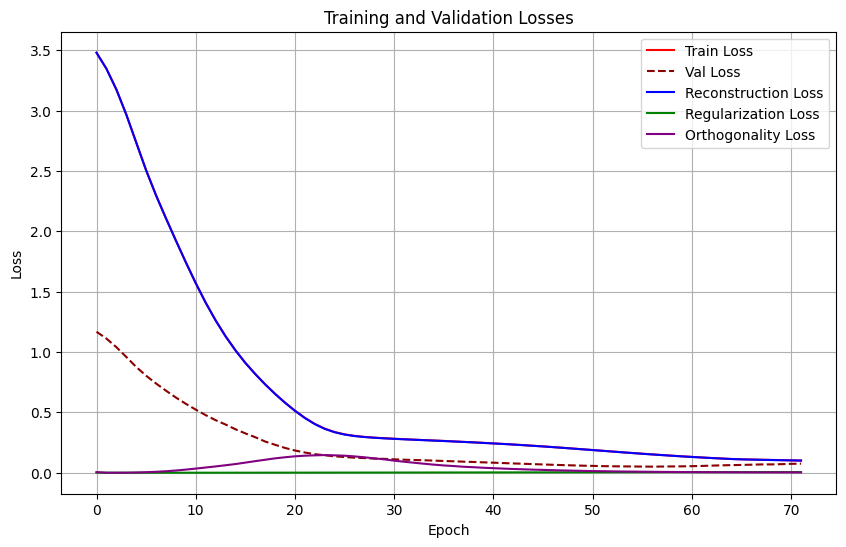

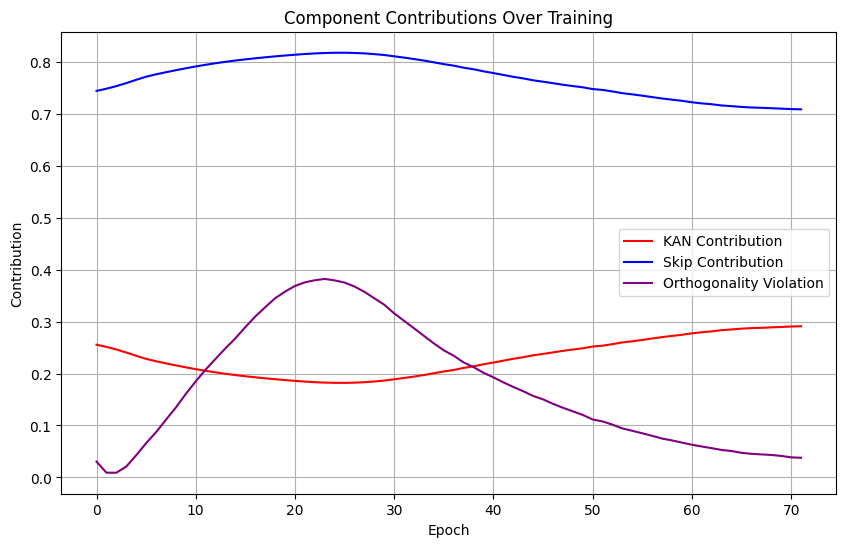

In [70]:
import matplotlib.pyplot as plt

def plot_losses(history):
    plt.figure(figsize=(10, 6))

    # Plot main losses
    plt.plot(history['train_loss'], color='red', label='Train Loss')
    plt.plot(history['val_loss'], color='darkred', linestyle='--', label='Val Loss')

    # Plot component losses
    plt.plot(history['reconstruction_loss'], color='blue', label='Reconstruction Loss')
    plt.plot(history['regularization_loss'], color='green', label='Regularization Loss')
    plt.plot(history['orthogonality_loss'], color='purple', label='Orthogonality Loss')

    # plt.yscale('log')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Losses')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_contribution(history):
    plt.figure(figsize=(10, 6))

    # Plot gate contributions
    plt.plot(history['kan_contribution'], color='red', label='KAN Contribution')
    plt.plot(history['skip_contribution'], color='blue', label='Skip Contribution')
    # plt.plot(history['gate_value'], color='green', label='Gate Value')  c'est égal à kan_contribution
    plt.plot(history['orthogonality_violation'], color='purple', label='Orthogonality Violation')

    plt.xlabel('Epoch')
    plt.ylabel('Contribution')
    plt.title('Component Contributions Over Training')
    plt.legend()
    plt.grid(True)
    plt.show()


plot_losses(history)

plot_contribution(history)

In [ ]:
from src.models.gated_kan_ae import GatedKANAutoencoder

# Initialize model with 7 input features (yield curve tenors)
# and 3 latent dimensions for level, slope, curvature to see if you can verify the Nelson-Siegel curve

gated_kan = GatedKANAutoencoder(
    input_dim=raw_dataset.shape[1],
    k=3,
    hidden_dims=[5, 4],
    
    basis_type="spline",
    M=16,
    poly_degree=5,
    xmin=-3.5,
    xmax=3.5,
    dropout_p=0.001,
    use_silu=True,
    
    gate_init=0.5,
    skip_rank=None,
    
    loss_type="huber",
    huber_delta=1,
    
    lambda_alpha=0.0001,
    lambda_group=0.00001,
    lambda_tv=0.0001,
    lambda_poly_decay=0,
    lambda_orthogonal=0.01,
    lambda_gate_reg=0.0001
)
